In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import audio_functions as af
import plot
from timeit import default_timer as timer
import json
import soundfile as sf
from scipy.io import wavfile
import acoustics
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [2]:
def cont_signal_ploter(t, signal, labels = ("Tiempo [s]","Amplitud"), xlimits = (None, None), ylimits = (None, None), xscale = "linear", yscale = "linear", x_mathtext = False, y_mathtext = False, x_ticks = (None), y_ticks = (None), title = "", col = "#1f77b4", grid = True, size = (8, 4), save = False, file_name = "mi_grafico", image_dpi = 200):
    """
    Plot a continuous signal.

    Parameters:
    -----------
    t : numpy.ndarray
        Array of time values
    signal : numpy.ndarray
        Array containing the signal values
    labels : tuple, optional
        Labels for the x and y axes (default is ("Tiempo [s]", "Amplitud"))
    xlimits : tuple, optional
        Tuple specifying the minimum and maximum values for the x-axis
    ylimits : tuple, optional
        Tuple specifying the minimum and maximum values for the y-axis
    xscale : str, optional
        Scaling type for the x-axis (default is "linear")
    yscale : str, optional
        Scaling type for the y-axis (default is "linear")
    x_mathtext : bool, optional
        Use MathText for the x-axis labels (default is False)
    y_mathtext : bool, optional
        Use MathText for the y-axis labels (default is False)
    title : str, optional
        Title of the plot (default is "")
    col : str, optional
        Color of the signal plot (default is "#1f77b4").
    grid : bool, optional
        Enable grid lines on the plot (default is True).
    size : tuple, optional
        Size of the plot figure in inches (default is (8, 4)).
    save : bool, optional
        Save the plot as an image file (default is False).
    file_name : str, optional
        Name of the saved image file (default is "my_plot").
    image_dpi : int, optional
        DPI (dots per inch) for the saved image file (default is 200).

    Returns:
    --------
    None
    """
    x, y = labels
    xlim_min, xlim_max = xlimits
    ylim_min, ylim_max = ylimits
    x_fig_size, y_fig_size = size
    
    fig, ax = plt.subplots()
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    fig.set_size_inches(x_fig_size, y_fig_size)
    
    ax.plot(t, signal, color = col)
        
    if grid == True:
        plt.grid(alpha = 0.7)
    elif grid == False:
        pass
    if x_mathtext == True:
        ax.ticklabel_format(axis = "x", scilimits = (0, 0), useLocale = True, useMathText = True)
    else:
        pass
    if y_mathtext == True:
        ax.ticklabel_format(axis = "y", scilimits = (0,0), useLocale = True, useMathText = True)
    else:
        pass
    if xlim_min != None or xlim_max != None:
        ax.set_xlim(xlim_min, xlim_max)
    else:
        ax.set_xlim(auto = True)
    
    if ylim_min != None or ylim_max != None:
        ax.set_ylim(ylim_min, ylim_max)
    else:
        ax.set_ylim(auto = True)


    if y_ticks != None:
        ax.set_yticks(y_ticks)
    else:
        pass
    
    if x_ticks != None:
        ax.set_xticks(x_ticks)
    else:
        pass
    
    #ax.xaxis.set_major_locator(MaxNLocator(nbins = "auto", integer=True, steps = [1, 2, 5, 10]))
    


    ax.set_title(title, fontsize=16)
    
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    
    if save == True:
        plt.savefig(f'{file_name}.png', dpi = image_dpi)
    
    plt.show()
    
    return

nominal_oct_central_freqs = [16, 31.5, 63, 125.0, 250.0, 500.0, 1000.0, 2000.0, 4000.0, 8000.0, 160000]

In [3]:
fs = 48000
room = af.simulate("prueba")
room.compute_rir()

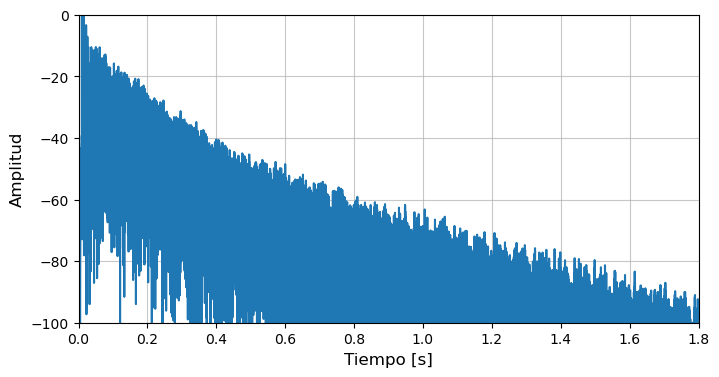

In [4]:
rir = room.rir[3][0]

dur_rir, t = af.get_audio_time_array(rir, fs)

rir_norm = rir/np.max(np.abs(rir))
rir_db = af.to_dB(rir_norm)
cont_signal_ploter(t,rir_db, ylimits=(-100, 0), xlimits=(0, 1.8))

rir_int16 = (rir_norm * 32767).astype(np.int16)
#wavfile.write("rir_prueba.wav", fs, rir_int16)

#rir.Signal.to_wav("rir_prueba.wav", depth=32)
#acoustics.Signal.to_wav(rir, "rir_prueba.wav", depth=32)
wavfile.write("rir_pueba.wav", 48000, rir_int16)

In [5]:
def schroeder_integral(rir: np.ndarray) -> np.ndarray:
    """Calcula la curva de decaimiento de energía acumulada inversa (Schroeder)."""
    power = rir**2
    return np.cumsum(power[::-1])[::-1]

def estimate_reverberation_time(rir: np.ndarray, fs: int, method: str = "RT60",plot: bool = False) -> float:
    """
    Estima el tiempo de reverberación (RT60 o T30) desde una RIR usando integración de Schroeder.
    
    Parámetros:
    - rir: array 1D con la respuesta al impulso (normalizada o no).
    - fs: frecuencia de muestreo [Hz].
    - method: "RT60" (usa -5 a -35 dB) o "T30" (usa -5 a -35 dB y extrapola).
    - plot: si True, muestra el gráfico del decaimiento y el ajuste.

    Devuelve:
    - Tiempo de reverberación estimado en segundos.
    """
    # Normalizar RIR si hace falta
    rir = rir / np.max(np.abs(rir))

    # Integración de Schroeder
    energy_decay = schroeder_integral(rir)
    decay_db = 10 * np.log10(energy_decay / np.max(energy_decay))

    # Tiempo en segundos
    t = np.arange(len(rir)) / fs

    # Rango dB según el método
    if method.upper() == "RT60":
        start_db, end_db = -5, -65
    elif method.upper() == "RT30":
        start_db, end_db = -5, -35
    else:
        raise ValueError("Método no válido. Usá 'RT60' o 'RT30'.")

    # Máscara para el ajuste lineal
    mask = (decay_db < start_db) & (decay_db > end_db)

    if np.sum(mask) < 2:
        if method.upper() == "RT60":
            print("No hay suficiente decaimiento para estimar RT60. Intentando RT30.")
            return estimate_reverberation_time(rir, fs, method="RT30", plot=plot)
        else:
            raise ValueError("No hay suficiente decaimiento para estimar RT30.")

    # Ajuste lineal sobre la caída
    slope, intercept, _, _, _ = linregress(t[mask], decay_db[mask])

    # Estimación final
    rt_est = -60 / slope

    # Opcional: graficar
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t, decay_db, label="Decaimiento de Schroeder (dB)")
        plt.plot(t[mask], slope * t[mask] + intercept, '--r', label=f"Ajuste lineal ({method})")
        plt.axhline(start_db, color='gray', linestyle='--', linewidth=0.5)
        plt.axhline(end_db, color='gray', linestyle='--', linewidth=0.5)
        plt.title(f"Estimación de reverberación: {method} = {rt_est:.3f} s")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Nivel [dB]")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    return rt_est


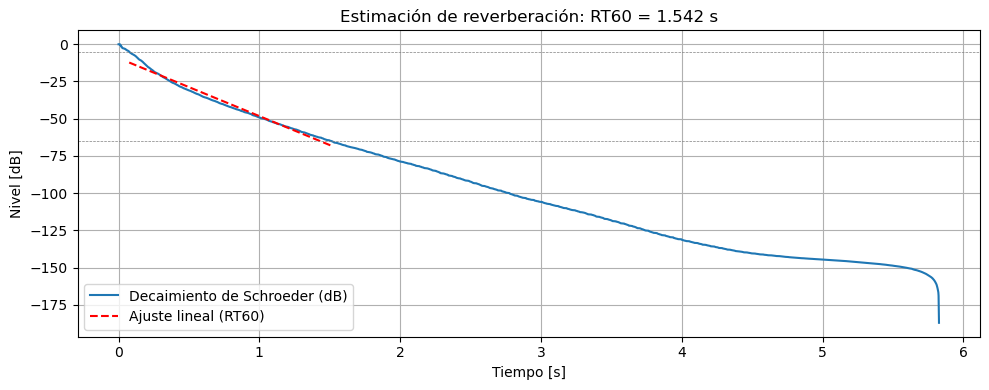

RT60 = 1.5416


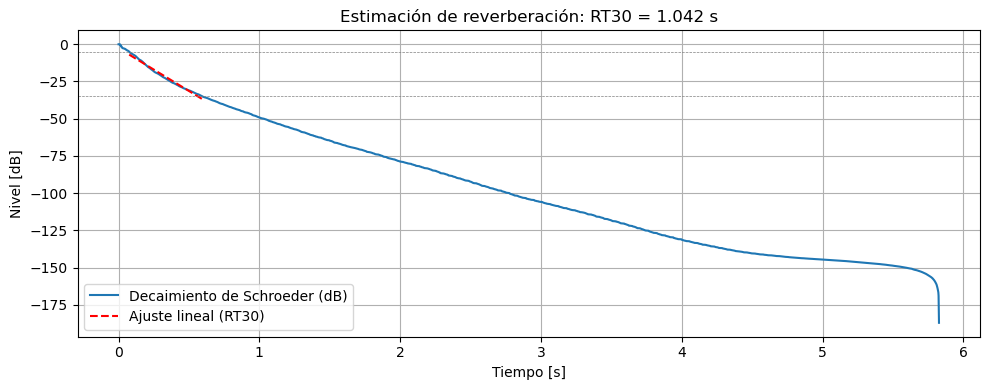

RT30 = 1.0424


In [6]:
rt60_est = estimate_reverberation_time(rir, fs, method='RT60', plot=True)
print(f'RT60 = {rt60_est:.4f}')
rt30_est = estimate_reverberation_time(rir, fs, method='RT30', plot=True)
print(f'RT30 = {rt30_est:.4f}')

El RT60 real es: 1000 ms
La función experimental tardó 0.05408010000246577
El RT60 experimental es 1415 ms
La función teórica tardó 0.00017530000332044438
El RT60 teórico es 995 ms
La diferencia con el experimental es: 41% 
La diferencia con el teórico es: -1%


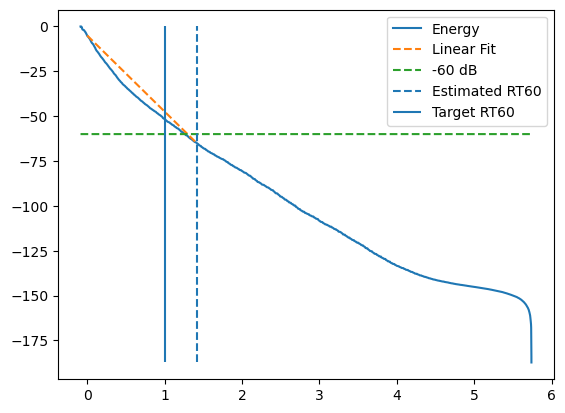

In [7]:
#Obtengo las grabaciones de los micrófonos
#señales_captadas = room.mic_array.signals

#Obtengo la rir
#room.compute_rir()

with open(f"simulaciones/prueba", "r") as f:
    sim_config = json.load(f)
t60_real = sim_config['room']['t60']
print(f"El RT60 real es: {t60_real* 1000:.0f} ms")

#Obtengo el T60 a partir de la rir, cualquiera de los dos métodos anda más o menos (son una poronga)
init_time = timer()
t60_experimental = pra.experimental.rt60.measure_rt60(room.rir[0][0], fs=room.fs, rt60_tgt=t60_real, plot=True)
end_time = timer()
tiempo_total = end_time - init_time
print(f"La función experimental tardó {tiempo_total}")
print(f"El RT60 experimental es {t60_experimental * 1000:.0f} ms")

init_time = timer()
t60_clasico = room.rt60_theory()
end_time = timer()
tiempo_total = end_time - init_time
print(f"La función teórica tardó {tiempo_total}")
print(f"El RT60 teórico es {t60_clasico * 1000:.0f} ms")

t60_diff_exp = ((t60_experimental/t60_real) - 1) * 100

t60_diff_clas = ((t60_clasico/t60_real) - 1) * 100

print(f"La diferencia con el experimental es: {t60_diff_exp:.0f}% \nLa diferencia con el teórico es: {t60_diff_clas:.0f}%")

#plt.figure()
#room.plot_rir()
#plt.grid()

#Notar que de las grabaciones tomo el 0, si hubieran más mics lo elijo a partir de ese índice
#af.play_audio(señales_captadas[0], fs)

In [8]:
audio, fs = af.load_audio("audios_anecoicos/p336_001.wav")

audio_auralized = af.reverb(rir_norm, audio, fs, fs)

dur, t = af.get_audio_time_array(audio_auralized, fs)

af.play_audio(audio_auralized, fs)


In [9]:
af.play_audio(rir, fs)

In [10]:
def rir_gen(tr, sr, amp = 1, t0 = 0, db_noise_floor = 0):
    """
    Generate a Room Impulse Response (RIR) signal.

    Parameters:
    -----------
    tr : float
        The value of the RT60 in seconds
    sr : int
        The sample rate in Hz
    amp : float, optional (default=1)
        an amplitude factor for the RIR
    t0 : float, optional (default=0)
        The time offset for the signal
    db_noise_floor : float, optional (default=0)
        The level of the noise floor in decibels

    Returns:
    --------
    sr : int
        The sample rate ot the RIR
    rir_synth : numpy.ndarray
        Array of amplitudes
    t : numpy.ndarray
        Array of time values
    """
    
    dur = int(tr)+1
    t = np.linspace(0, dur, dur*sr)
    
    noise = np.random.normal(0,1,t.size)
    
    tau = tr/np.log(1000)
    envelope = amp*np.exp(-(t-t0)/tau)
    
    u = np.piecewise(t, t >= t0, [1, 0])
    
    if db_noise_floor == 0:
        rir_synth = envelope * noise * u
    else:
        assert type(sr) == int, ("The sample rate must be an int")
        if db_noise_floor > -60:
            print("The specified noise floor is relatively high")
        amp_noise = 10 ** (db_noise_floor/20)
        rir_synth = envelope * noise * u + amp_noise * noise
    
    rir_synth = rir_synth / np.max(np.abs(rir_synth))
    
    return t, rir_synth

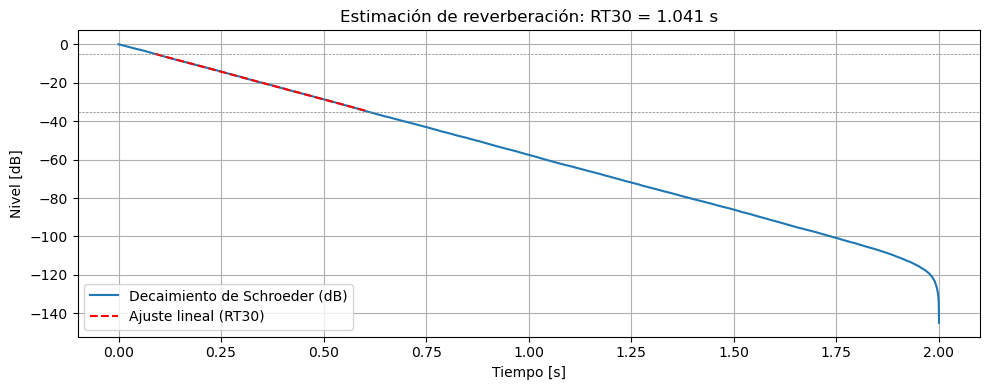

In [16]:
t_30, rir_T30 = rir_gen(rt30_est, fs)
t_60, rir_T60 = rir_gen(rt60_est, fs)

estimate_reverberation_time(rir_T30, fs, method='RT30', plot=True)

audio_auralized_t30 = af.reverb(rir_T30, audio, fs, fs)
audio_auralized_t60 = af.reverb(rir_T60, audio, fs, fs)

af.play_audio(audio_auralized_t30, fs)

In [12]:
af.play_audio(audio_auralized_t60, fs)

In [13]:
af.play_audio(rir_T30, fs)

In [14]:
af.play_audio(rir_T60, fs)

c:\Users\KP\anaconda3\Lib\site-packages\acoustics\room.py:203: RuntimeWarning: divide by zero encountered in log10
  sch_db = 10.0 * np.log10(sch / np.max(sch))


[   16.     31.5    63.    125.    250.    500.   1000.   2000.   4000.
  8000.  16000. ] 
[1.985 2.001 1.906 2.243 1.853 1.59  1.451 1.302 1.209 0.752 0.688]


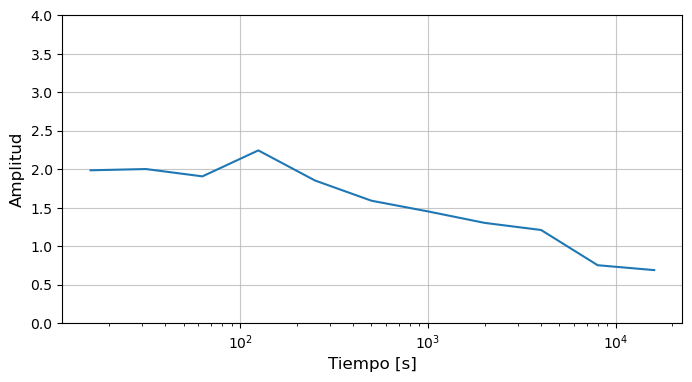

In [15]:

bands = acoustics.bands.octave(20, 20000)

rt_30 = acoustics.room.t60_impulse("rir_pueba.wav", bands, rt='t30')

dur, t_2 = af.get_audio_time_array(rt_30, fs)

print(f'{bands} \n{np.round(rt_30,3)}')

cont_signal_ploter(bands, rt_30, xscale='log', ylimits=(0, 4))
